## ENTRENAMIETO DE LOS MODELOS: CLASIFICACIÓN DE GÉNEROS MUSICALES


In [ ]:
# ============================================================
# 🧰 LIBRERÍAS PRINCIPALES
# ============================================================
import os
import math
import warnings
from datetime import datetime

# ============================================================
# 📊 MANEJO Y ANÁLISIS DE DATOS
# ============================================================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ============================================================
# 🤖 MACHINE LEARNING - MODELOS
# ============================================================
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree

# ============================================================
# 📈 MÉTRICAS Y EVALUACIÓN DE MODELOS
# ============================================================
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score,
    roc_curve,
    auc,
    roc_auc_score
)

from itertools import cycle


warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## 1. CARGA DE DATOS

In [2]:
print("Cargando dataset...")
df = pd.read_csv('../data/processed/04_dataset_filtrado.csv')

print(f"\nDataset cargado: {df.shape[0]} filas, {df.shape[1]} columnas")

Cargando dataset...

Dataset cargado: 743 filas, 20 columnas


## 2. VERIFICACION

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 743 entries, 0 to 742
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artista           743 non-null    object 
 1   tema              743 non-null    object 
 2   genero            743 non-null    object 
 3   popularidad       743 non-null    float64
 4   fuente            743 non-null    object 
 5   spotify_id        743 non-null    object 
 6   año               617 non-null    float64
 7   id                743 non-null    object 
 8   href              743 non-null    object 
 9   acousticness      743 non-null    float64
 10  danceability      743 non-null    float64
 11  energy            743 non-null    float64
 12  instrumentalness  743 non-null    float64
 13  key               743 non-null    float64
 14  liveness          743 non-null    float64
 15  loudness          743 non-null    float64
 16  mode              743 non-null    float64
 1

In [9]:
df['genero'].value_counts()

genero
rock           150
hiphop         150
regueton        90
kpop            70
electronica     61
country         56
pop             50
hyperpop        43
jazz            39
blues           18
clasica         16
Name: count, dtype: int64

### Convertir columnas a números enteros

In [7]:
# Convertir columnas a números enteros
columnas_a_convertir = ['popularidad', 'año', 'key', 'mode']

for columna in columnas_a_convertir:
    if columna in df.columns:
        # Primero rellenamos los NaN con 0 (o puedes usar otro valor)
        df[columna] = df[columna].fillna(0).astype('int64')

# Verificar los cambios
df[columnas_a_convertir].info()
print("\nPrimeras filas después de la conversión:")
print(df[columnas_a_convertir].head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 743 entries, 0 to 742
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   popularidad  743 non-null    int64
 1   año          743 non-null    int64
 2   key          743 non-null    int64
 3   mode         743 non-null    int64
dtypes: int64(4)
memory usage: 23.3 KB

Primeras filas después de la conversión:
   popularidad   año  key  mode
0           15  2024    2     1
1           27  2024    0     1
2           10  2024    7     1
3           15  2025   11     0
4           14  2024    0     1


## 3. PREPARACIÓN DE VARIABLES y LABEL ENCODER

In [20]:
features_audio = ['popularidad','acousticness', 'danceability', 'energy', 'instrumentalness',
                  'key', 'liveness', 'loudness', 'mode', 'speechiness',
                  'tempo', 'valence']

# Separar características (X) y objetivo (y)
X = df[features_audio]
y = df['genero']

# Codificar las etiquetas de género
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
# Mostrar la distribución con nombres de géneros
generos = label_encoder.classes_

print(f"\nPredictoras (X): {X.shape}")
print(f"\nObjetivo (y): {y_encoded.shape}")
print(f"\nGéneros únicos: {label_encoder.classes_}")


Predictoras (X): (743, 12)

Objetivo (y): (743,)

Géneros únicos: ['blues' 'clasica' 'country' 'electronica' 'hiphop' 'hyperpop' 'jazz'
 'kpop' 'pop' 'regueton' 'rock']


## 4. DIVISIÓN DE DATOS

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

print(f"{X_train.shape[0]} muestras de entrenamiento. \nDistribución de géneros:")
print(pd.Series(label_encoder.inverse_transform(y_train)).value_counts())

print(f"\n{X_test.shape[0]} muestras de prueba. \nDistribución de géneros:")
print(pd.Series(label_encoder.inverse_transform(y_test)).value_counts())

594 muestras de entrenamiento. 
Distribución de géneros:
rock           120
hiphop         120
regueton        72
kpop            56
electronica     49
country         45
pop             40
hyperpop        34
jazz            31
blues           14
clasica         13
Name: count, dtype: int64

149 muestras de prueba. 
Distribución de géneros:
rock           30
hiphop         30
regueton       18
kpop           14
electronica    12
country        11
pop            10
hyperpop        9
jazz            8
blues           4
clasica         3
Name: count, dtype: int64


## 5. NORMALIZACIÓN DE DATOS

In [22]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Normalización completada")


Normalización completada


## 6. ENTRENAMIENTO DE MODELOS

In [51]:
print("ENTRENAMIENTO DE MODELOS")
# Diccionario para almacenar resultados
resultados = {}


# ---------- MODELO 1: K-NEAREST NEIGHBORS (KNN) ----------
print("\nModelo 1: K-Nearest Neighbors (KNN)")
print("-" * 50)

# Buscar el mejor valor de k
print("Buscando el mejor valor de k...")
k_values = range(1, 31)
cv_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

best_k = k_values[np.argmax(cv_scores)]
print(f" Mejor k encontrado: {best_k} (accuracy: {max(cv_scores):.4f})")

# Entrenar KNN con el mejor k
knn_best = KNeighborsClassifier(n_neighbors=best_k)
knn_best.fit(X_train_scaled, y_train)
y_pred_knn = knn_best.predict(X_test_scaled)

# Métricas
acc_knn = accuracy_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn, average='weighted')

resultados['KNN'] = {
    'modelo': knn_best,
    'accuracy': acc_knn,
    'f1_score': f1_knn,
    'predictions': y_pred_knn
}

print(f" Accuracy: {acc_knn:.4f}")
print(f" F1-Score: {f1_knn:.4f}")



# ---------- MODELO 2: Decision Tress ----------
print("\n Modelo 2: Decision Tress")
print("-" * 50)

dt = DecisionTreeClassifier(criterion="gini", max_depth=3, random_state=42)
dt.fit(X_train_scaled, y_train)
y_pred_dt = dt.predict(X_test_scaled)

acc_dt = accuracy_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt, average='weighted')

resultados['Decision Tress'] = {
    'modelo': dt,
    'accuracy': acc_dt,
    'f1_score': f1_dt,
    'predictions': y_pred_dt
}

print(f" Accuracy: {acc_dt:.4f}")
print(f" F1-Score: {f1_dt:.4f}")



# ---------- MODELO 2b: RANDOM FOREST ----------
print("\n Modelo 2b Random Forest")
print("-" * 50)

rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

acc_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')

resultados['Random Forest'] = {
    'modelo': rf,
    'accuracy': acc_rf,
    'f1_score': f1_rf,
    'predictions': y_pred_rf
}

print(f" Accuracy: {acc_rf:.4f}")
print(f" F1-Score: {f1_rf:.4f}")



# ---------- MODELO 3: SVM - RBF Kernel ----------
print("\n Modelo 3: Support Vector Machine (SVM) - RBF Kernel")
print("-" * 50)

svm_rbf = SVC(kernel='rbf', random_state=42)
svm_rbf.fit(X_train_scaled, y_train)
y_pred_svm_rbf = svm_rbf.predict(X_test_scaled)

acc_svm_rbf = accuracy_score(y_test, y_pred_svm_rbf)
f1_svm_rbf = f1_score(y_test, y_pred_svm_rbf, average='weighted')

resultados['SVM (RBF)'] = {
    'modelo': svm_rbf,
    'accuracy': acc_svm_rbf,
    'f1_score': f1_svm_rbf,
    'predictions': y_pred_svm_rbf
}

print(f" Accuracy: {acc_svm_rbf:.4f}")
print(f" F1-Score: {f1_svm_rbf:.4f}")




# ---------- MODELO 4: SVM - Linear Kernel ----------
print("\n Modelo 4: Support Vector Machine (SVM) - Linear Kernel")
print("-" * 50)

svm_linear = SVC(kernel='linear', random_state=42)
svm_linear.fit(X_train_scaled, y_train)
y_pred_svm_linear = svm_linear.predict(X_test_scaled)

acc_svm_linear = accuracy_score(y_test, y_pred_svm_linear)
f1_svm_linear = f1_score(y_test, y_pred_svm_linear, average='weighted')

resultados['SVM (Linear)'] = {
    'modelo': svm_linear,
    'accuracy': acc_svm_linear,
    'f1_score': f1_svm_linear,
    'predictions': y_pred_svm_linear
}

print(f" Accuracy: {acc_svm_linear:.4f}")
print(f" F1-Score: {f1_svm_linear:.4f}")




# ---------- MODELO 5: SVM - Polynomial Kernel ----------
print("\n Modelo 5: Support Vector Machine (SVM) - Polynomial Kernel")
print("-" * 50)

svm_poly = SVC(kernel='poly', degree=3, random_state=42)
svm_poly.fit(X_train_scaled, y_train)
y_pred_svm_poly = svm_poly.predict(X_test_scaled)

acc_svm_poly = accuracy_score(y_test, y_pred_svm_poly)
f1_svm_poly = f1_score(y_test, y_pred_svm_poly, average='weighted')

resultados['SVM (Polynomial)'] = {
    'modelo': svm_poly,
    'accuracy': acc_svm_poly,
    'f1_score': f1_svm_poly,
    'predictions': y_pred_svm_poly
}

print(f" Accuracy: {acc_svm_poly:.4f}")
print(f" F1-Score: {f1_svm_poly:.4f}")





# ---------- MODELO 6: SVM - Sigmoid Kernel ----------
print("\n Modelo 6: Support Vector Machine (SVM) - Sigmoid Kernel")
print("-" * 50)

svm_sigmoid = SVC(kernel='sigmoid', random_state=42)
svm_sigmoid.fit(X_train_scaled, y_train)
y_pred_svm_sigmoid = svm_sigmoid.predict(X_test_scaled)

acc_svm_sigmoid = accuracy_score(y_test, y_pred_svm_sigmoid)
f1_svm_sigmoid = f1_score(y_test, y_pred_svm_sigmoid, average='weighted')

resultados['SVM (Sigmoid)'] = {
    'modelo': svm_sigmoid,
    'accuracy': acc_svm_sigmoid,
    'f1_score': f1_svm_sigmoid,
    'predictions': y_pred_svm_sigmoid
}

print(f" Accuracy: {acc_svm_sigmoid:.4f}")
print(f" F1-Score: {f1_svm_sigmoid:.4f}")




# ---------- MODELO 7: REGRESIÓN LOGÍSTICA ----------
print("\n Modelo 7: Regresión Logística")
print("-" * 50)

from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial', solver='lbfgs')
log_reg.fit(X_train_scaled, y_train)
y_pred_log_reg = log_reg.predict(X_test_scaled)

acc_log_reg = accuracy_score(y_test, y_pred_log_reg)
f1_log_reg = f1_score(y_test, y_pred_log_reg, average='weighted')

resultados['Regresión Logística'] = {
    'modelo': log_reg,
    'accuracy': acc_log_reg,
    'f1_score': f1_log_reg,
    'predictions': y_pred_log_reg
}

print(f" Accuracy: {acc_log_reg:.4f}")
print(f" F1-Score: {f1_log_reg:.4f}")

ENTRENAMIENTO DE MODELOS

Modelo 1: K-Nearest Neighbors (KNN)
--------------------------------------------------
Buscando el mejor valor de k...
 Mejor k encontrado: 17 (accuracy: 0.5943)
 Accuracy: 0.6174
 F1-Score: 0.5832

 Modelo 2: Decision Tress
--------------------------------------------------
 Accuracy: 0.5034
 F1-Score: 0.4591

 Modelo 2b Random Forest
--------------------------------------------------
 Accuracy: 0.7852
 F1-Score: 0.7755

 Modelo 3: Support Vector Machine (SVM) - RBF Kernel
--------------------------------------------------
 Accuracy: 0.7181
 F1-Score: 0.6972

 Modelo 4: Support Vector Machine (SVM) - Linear Kernel
--------------------------------------------------
 Accuracy: 0.6846
 F1-Score: 0.6525

 Modelo 5: Support Vector Machine (SVM) - Polynomial Kernel
--------------------------------------------------
 Accuracy: 0.5638
 F1-Score: 0.4864

 Modelo 6: Support Vector Machine (SVM) - Sigmoid Kernel
--------------------------------------------------
 Accura

## 7. COMPARACIÓN DE MODELOS

In [52]:
print("COMPARACIÓN DE MODELOS")

comparacion = pd.DataFrame({
    'Modelo': list(resultados.keys()),
    'Accuracy': [resultados[m]['accuracy'] for m in resultados],
    'F1-Score': [resultados[m]['f1_score'] for m in resultados]
})

print("\n", comparacion.to_string(index=False))

mejor_modelo_nombre = comparacion.loc[comparacion['Accuracy'].idxmax(), 'Modelo']
mejor_modelo = resultados[mejor_modelo_nombre]['modelo']
mejor_predictions = resultados[mejor_modelo_nombre]['predictions']

print(f"\n MEJOR MODELO: {mejor_modelo_nombre}")
print(f" Accuracy: {resultados[mejor_modelo_nombre]['accuracy']:.4f}")
print(f" F1-Score: {resultados[mejor_modelo_nombre]['f1_score']:.4f}")



# Crear carpeta si no existe
os.makedirs("../reports/models", exist_ok=True)
# Crear nombre del archivo con fecha/hora
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
nombre_archivo = f"../reports/models/resultados_modelos_{timestamp}.txt"

# Guardar los resultados
with open(nombre_archivo, "w", encoding="utf-8") as f:
    f.write("COMPARACIÓN DE MODELOS\n")
    f.write("="*60 + "\n\n")
    f.write(comparacion.to_string(index=False))
    
    # Escribir mejor modelo
    f.write(f"\n\nMEJOR MODELO: {mejor_modelo_nombre}\n")
    f.write(f"Accuracy: {resultados[mejor_modelo_nombre]['accuracy']:.4f}\n")
    f.write(f"F1-Score: {resultados[mejor_modelo_nombre]['f1_score']:.4f}\n")

print(f"Resultados guardados en: {nombre_archivo}")


COMPARACIÓN DE MODELOS

              Modelo  Accuracy  F1-Score
                KNN  0.617450  0.583190
     Decision Tress  0.503356  0.459053
      Random Forest  0.785235  0.775460
          SVM (RBF)  0.718121  0.697175
       SVM (Linear)  0.684564  0.652470
   SVM (Polynomial)  0.563758  0.486408
      SVM (Sigmoid)  0.583893  0.571349
Regresión Logística  0.691275  0.662331

 MEJOR MODELO: Random Forest
 Accuracy: 0.7852
 F1-Score: 0.7755
Resultados guardados en: ../reports/models/resultados_modelos_2025-11-10_17-14-50.txt


## 8. VISUALIZACIONES


Generando visualizaciones...


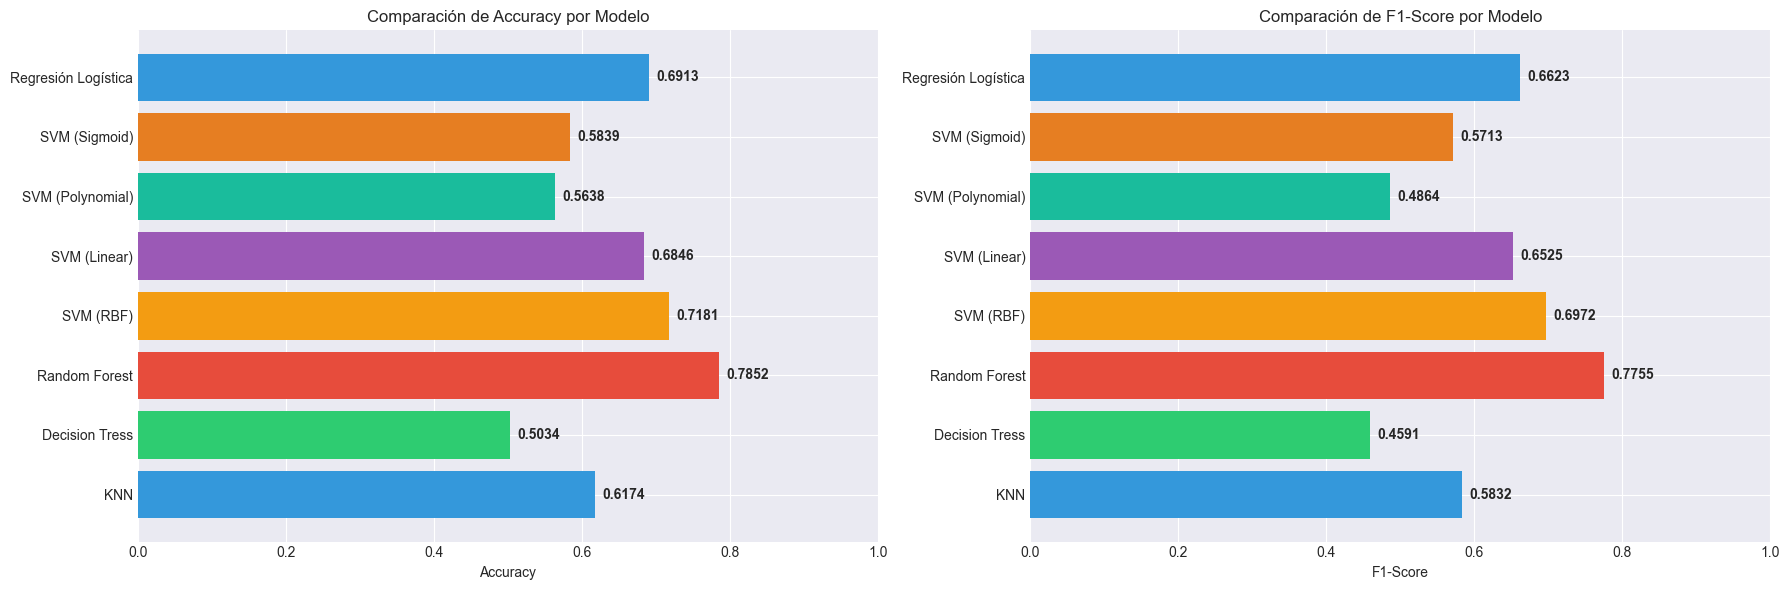

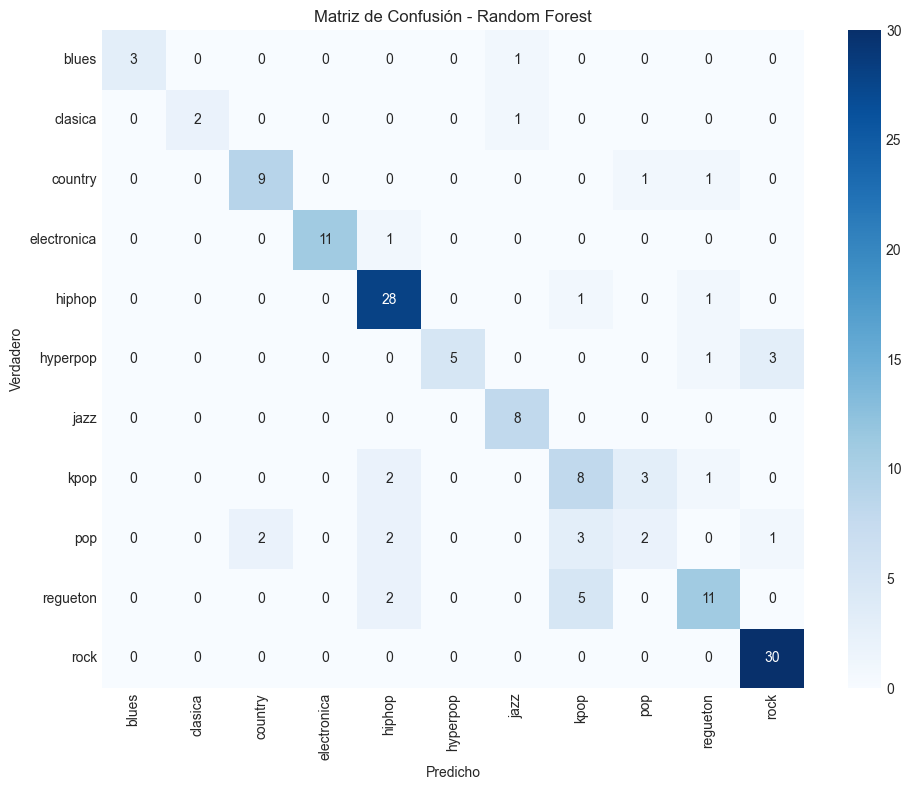

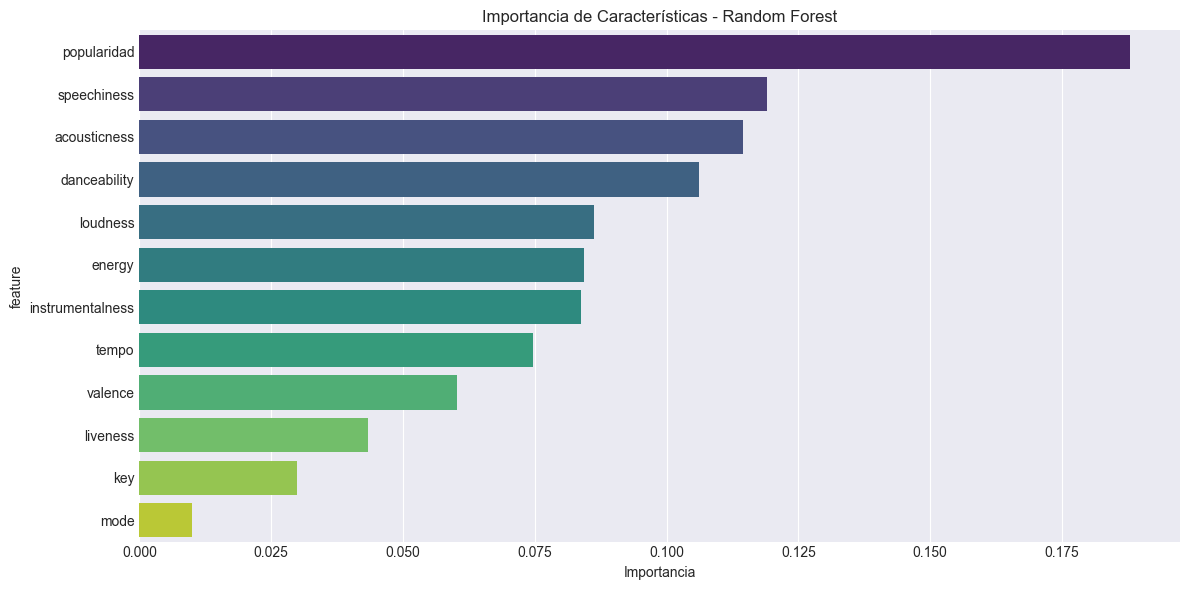

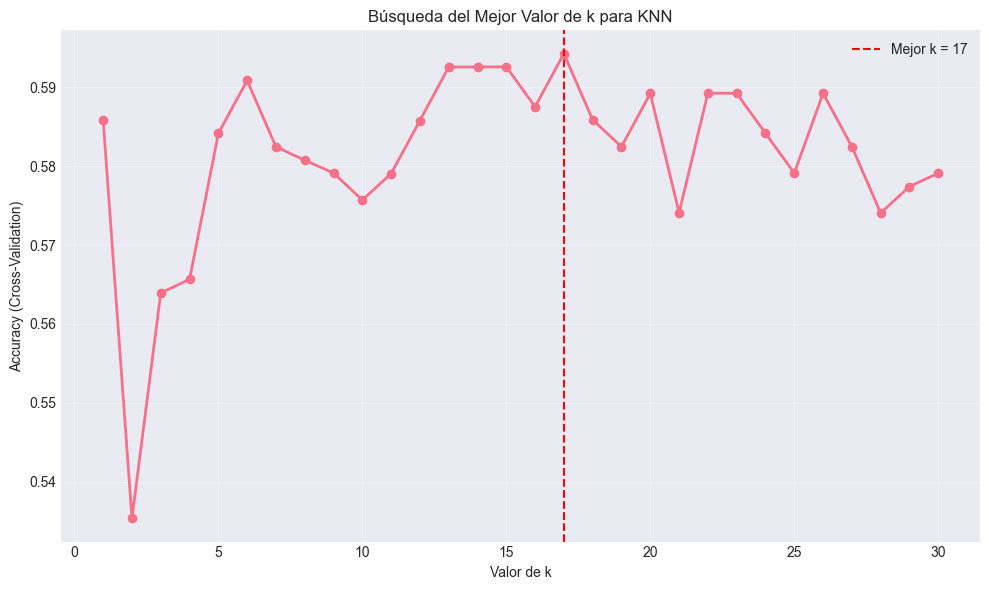


Generando comparación de kernels SVM...


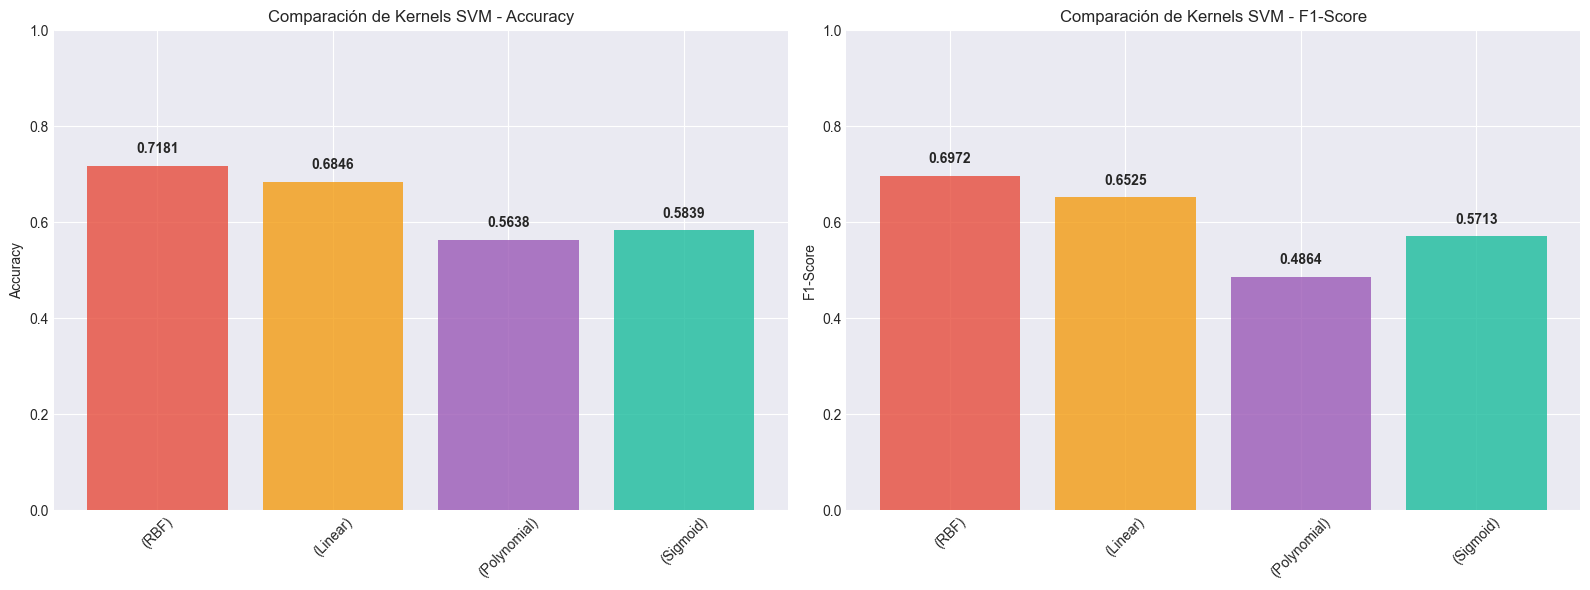

In [54]:
print("\nGenerando visualizaciones...")

# Visualización 1: Comparación de modelos
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Colores para cada modelo
colores = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12', '#9b59b6', '#1abc9c', '#e67e22']

# Accuracy
axes[0].barh(comparacion['Modelo'], comparacion['Accuracy'], color=colores[:len(comparacion)])
axes[0].set_xlabel('Accuracy')
axes[0].set_title('Comparación de Accuracy por Modelo')
axes[0].set_xlim([0, 1])
for i, v in enumerate(comparacion['Accuracy']):
    axes[0].text(v + 0.01, i, f'{v:.4f}', va='center', fontweight='bold')

# F1-Score
axes[1].barh(comparacion['Modelo'], comparacion['F1-Score'], color=colores[:len(comparacion)])
axes[1].set_xlabel('F1-Score')
axes[1].set_title('Comparación de F1-Score por Modelo')
axes[1].set_xlim([0, 1])
for i, v in enumerate(comparacion['F1-Score']):
    axes[1].text(v + 0.01, i, f'{v:.4f}', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../reports/figures/05-comparacion_modelos.png', dpi=300, bbox_inches='tight')
plt.show()

# Visualización 2: Matriz de confusión del mejor modelo
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, mejor_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title(f'Matriz de Confusión - {mejor_modelo_nombre}')
plt.ylabel('Verdadero')
plt.xlabel('Predicho')
plt.tight_layout()
plt.savefig('../reports/figures/05-matriz_confusion.png', dpi=300, bbox_inches='tight')
plt.show()


# Visualización 3: Importancia de características (Random Forest)
if 'Random Forest' in resultados:
    plt.figure(figsize=(12, 6))
    feature_importance = pd.DataFrame({
        'feature': features_audio,
        'importance': resultados['Random Forest']['modelo'].feature_importances_
    }).sort_values('importance', ascending=False)

    sns.barplot(data=feature_importance, x='importance', y='feature', palette='viridis')
    plt.title('Importancia de Características - Random Forest')
    plt.xlabel('Importancia')
    plt.tight_layout()
    plt.savefig('../reports/figures/05-importancia_caracteristicas.png', dpi=300, bbox_inches='tight')
    plt.show()

# Visualización 4: Curva de k para KNN
plt.figure(figsize=(10, 6))
plt.plot(k_values, cv_scores, marker='o', linestyle='-', linewidth=2)
plt.axvline(x=best_k, color='r', linestyle='--', label=f'Mejor k = {best_k}')
plt.xlabel('Valor de k')
plt.ylabel('Accuracy (Cross-Validation)')
plt.title('Búsqueda del Mejor Valor de k para KNN')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../reports/figures/05-curva_k_knn.png', dpi=300, bbox_inches='tight')
plt.show()


# Visualización 5: Comparación de kernels SVM
print("\nGenerando comparación de kernels SVM...")
svm_models = {k: v for k, v in resultados.items() if 'SVM' in k}

if len(svm_models) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    svm_df = pd.DataFrame({
        'Kernel': [k.replace('SVM ', '') for k in svm_models.keys()],
        'Accuracy': [v['accuracy'] for v in svm_models.values()],
        'F1-Score': [v['f1_score'] for v in svm_models.values()]
    })

    # Gráfico de Accuracy
    axes[0].bar(svm_df['Kernel'], svm_df['Accuracy'],
               color=['#e74c3c', '#f39c12', '#9b59b6', '#1abc9c'], alpha=0.8)
    axes[0].set_ylabel('Accuracy')
    axes[0].set_title('Comparación de Kernels SVM - Accuracy')
    axes[0].set_ylim([0, 1])
    axes[0].tick_params(axis='x', rotation=45)
    for i, v in enumerate(svm_df['Accuracy']):
        axes[0].text(i, v + 0.02, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

    # Gráfico de F1-Score
    axes[1].bar(svm_df['Kernel'], svm_df['F1-Score'],
               color=['#e74c3c', '#f39c12', '#9b59b6', '#1abc9c'], alpha=0.8)
    axes[1].set_ylabel('F1-Score')
    axes[1].set_title('Comparación de Kernels SVM - F1-Score')
    axes[1].set_ylim([0, 1])
    axes[1].tick_params(axis='x', rotation=45)
    for i, v in enumerate(svm_df['F1-Score']):
        axes[1].text(i, v + 0.02, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.savefig('../reports/figures/05-comparacion_kernels_svm.png', dpi=300, bbox_inches='tight')
    plt.show()

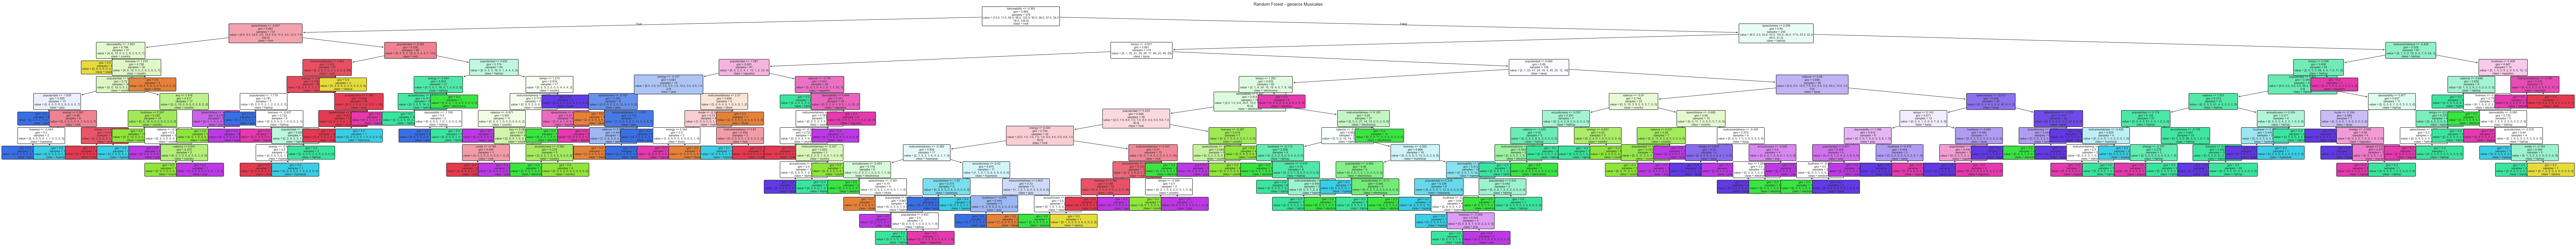

In [66]:
from sklearn import tree
import matplotlib.pyplot as plt

# Recuperar el modelo desde tu diccionario
mejor_modelo = resultados['Random Forest']['modelo']

# Tomar un árbol individual del bosque (por ejemplo, el primero)
arbol = mejor_modelo.estimators_[0]

# Crear figura
plt.figure(figsize=(128, 12))
tree.plot_tree(
    arbol,
    feature_names=X.columns,              # columnas de tus features
    class_names=label_encoder.classes_,   # nombres de las clases
    filled=True,
    rounded=True,
    fontsize=8
)
plt.title("Random Forest - generos Musicales")
plt.savefig('../reports/figures/05-random-forest-generos-musicales.png', dpi=300, bbox_inches='tight')
plt.show()


## 9. REPORTE DETALLADO DEL MEJOR MODELO

In [ ]:
print(f"REPORTE DETALLADO - {mejor_modelo_nombre}")

print("\nReporte de Clasificación:")
print(classification_report(y_test, mejor_predictions,target_names=label_encoder.classes_))

REPORTE DETALLADO - Random Forest

Reporte de Clasificación:
              precision    recall  f1-score   support

       blues       1.00      0.75      0.86         4
     clasica       1.00      0.67      0.80         3
     country       0.82      0.82      0.82        11
 electronica       1.00      0.92      0.96        12
      hiphop       0.80      0.93      0.86        30
    hyperpop       1.00      0.56      0.71         9
        jazz       0.80      1.00      0.89         8
        kpop       0.47      0.57      0.52        14
         pop       0.33      0.20      0.25        10
    regueton       0.73      0.61      0.67        18
        rock       0.88      1.00      0.94        30

    accuracy                           0.79       149
   macro avg       0.80      0.73      0.75       149
weighted avg       0.79      0.79      0.78       149

📊 Métricas de evaluación - Random Forest
              precision    recall  f1-score   support

       blues       1.00      0

### Cruva ROC por Genero

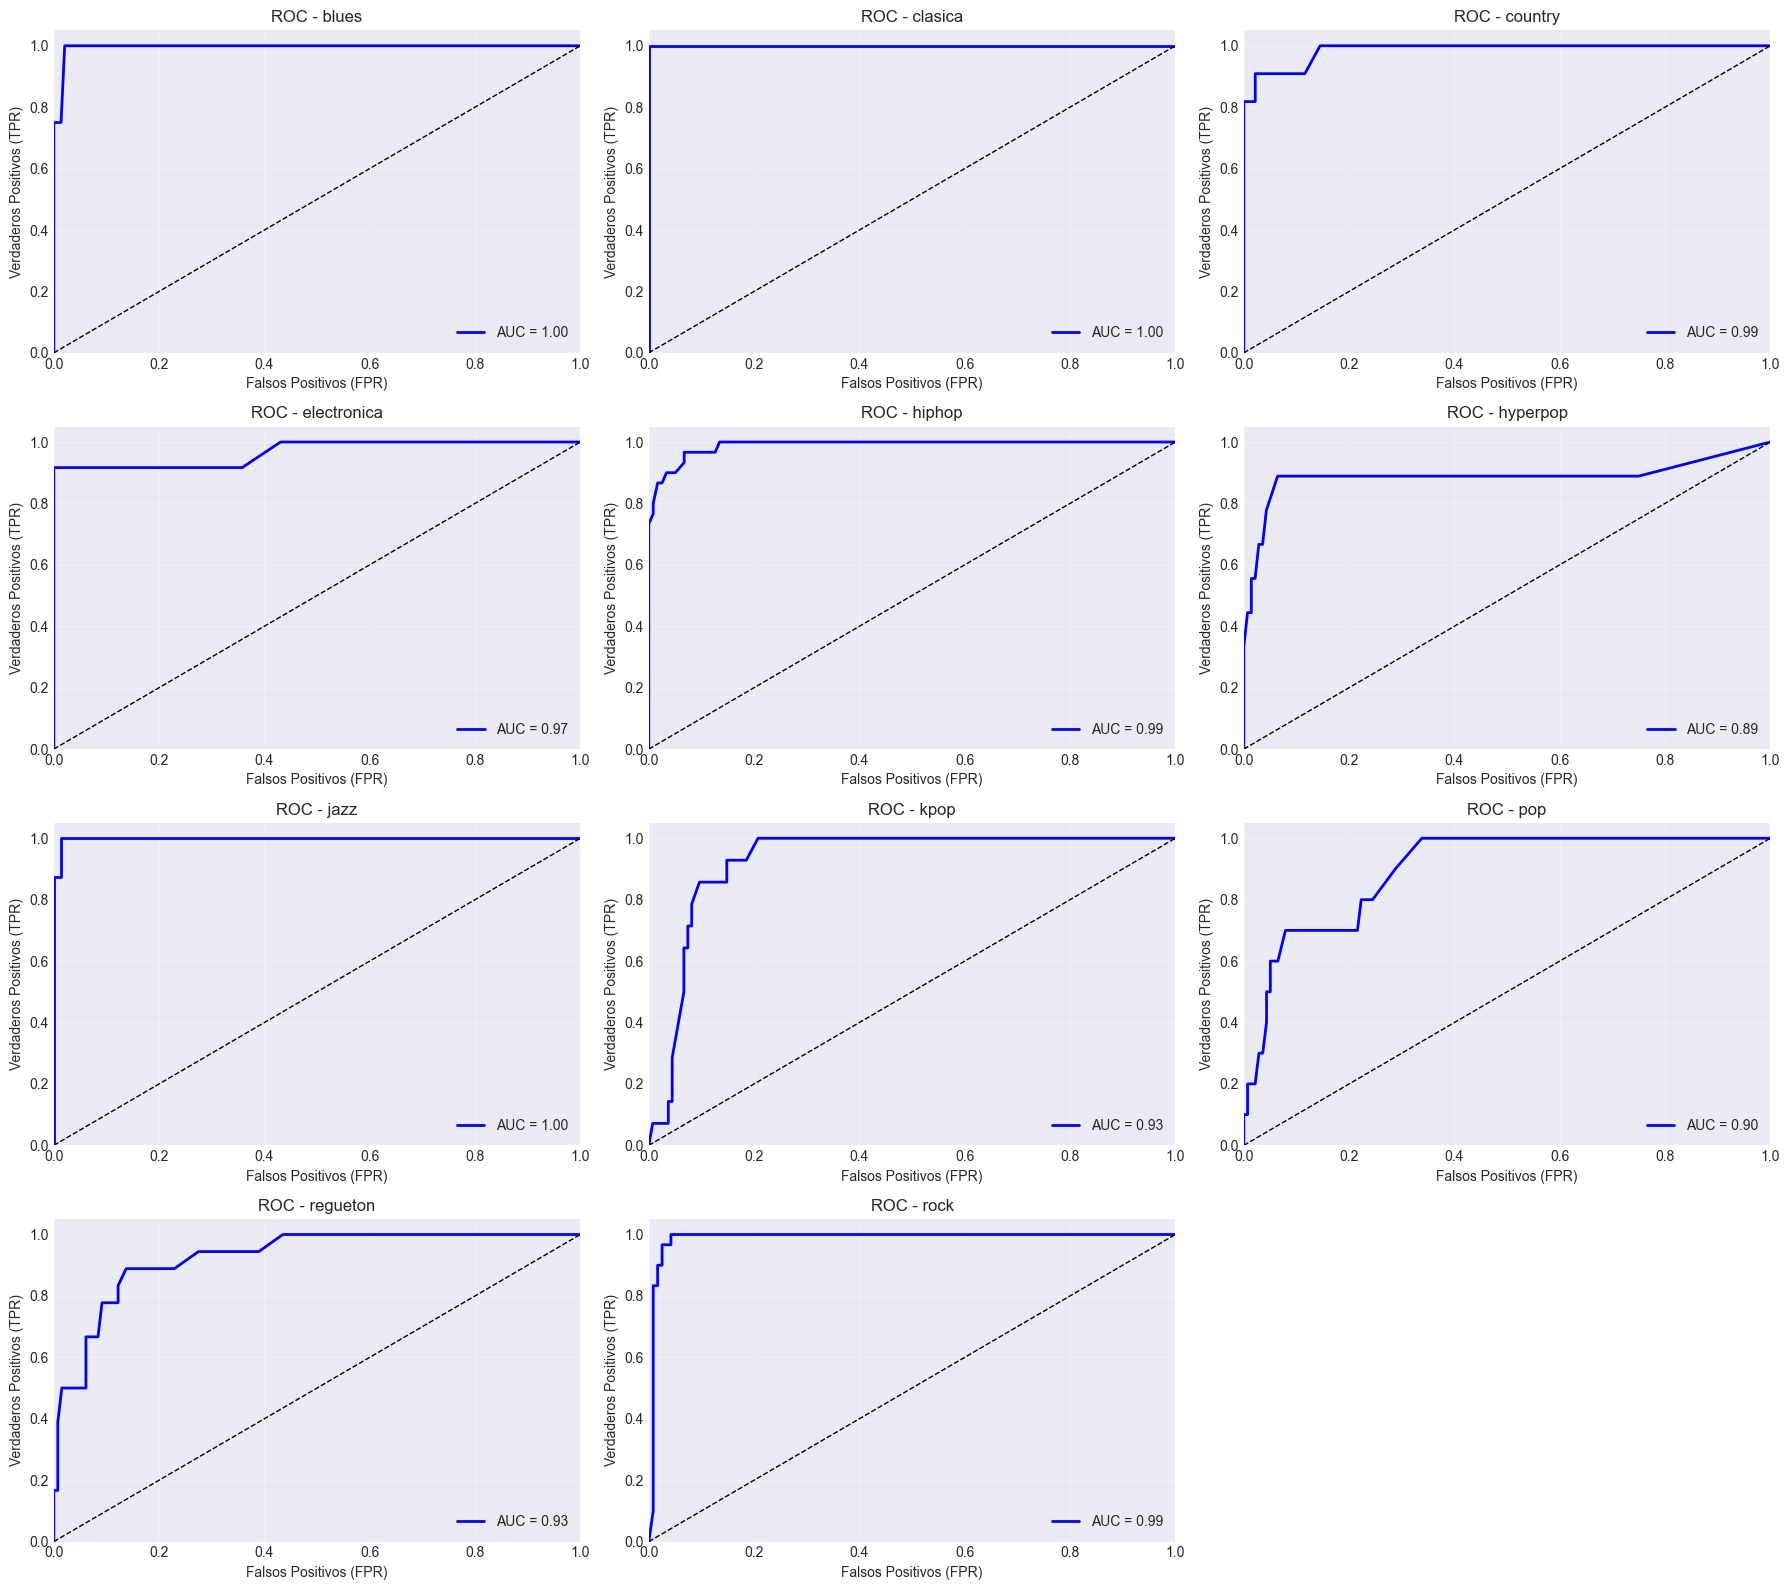

In [ ]:
#  Binarizar las etiquetas
y_test_bin = label_binarize(y_test, classes=range(len(label_encoder.classes_)))

#  Obtener probabilidades predichas del modelo
modelo = resultados['Random Forest']['modelo']
y_score = modelo.predict_proba(X_test_scaled)

#  Calcular ROC y AUC para cada género
n_classes = y_test_bin.shape[1]
fpr, tpr, roc_auc = {}, {}, {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#  Crear subplots
cols = 3  # cantidad de columnas
rows = math.ceil(n_classes / cols)

fig, axes = plt.subplots(rows, cols, figsize=(18, rows * 4))
axes = axes.flatten()  # para iterar fácilmente

#  Graficar una curva ROC por género
for i, ax in enumerate(axes):
    if i < n_classes:
        ax.plot(fpr[i], tpr[i], color='blue', lw=2,
                label=f"AUC = {roc_auc[i]:.2f}")
        ax.plot([0, 1], [0, 1], 'k--', lw=1)
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_title(f"ROC - {label_encoder.classes_[i]}")
        ax.set_xlabel('Falsos Positivos (FPR)')
        ax.set_ylabel('Verdaderos Positivos (TPR)')
        ax.legend(loc="lower right")
        ax.grid(alpha=0.3)
    else:
        ax.axis('off')  # dejar vacíos los subplots sobrantes

plt.tight_layout()
plt.show()


## 10. FUNCIÓN DE PREDICCIÓN

In [59]:
def predecir_genero(popularidad,acousticness, danceability, energy, instrumentalness,
                   key, liveness, loudness, mode, speechiness, tempo, valence):
    """
    Predice el género musical basado en características de audio
    """
    # Crear array con las características
    features = np.array([[popularidad,acousticness, danceability, energy, instrumentalness,
                         key, liveness, loudness, mode, speechiness, tempo, valence]])

    # Normalizar
    features_scaled = scaler.transform(features)

    # Predecir
    prediccion = mejor_modelo.predict(features_scaled)
    genero = label_encoder.inverse_transform(prediccion)

    return genero[0]

# Ejemplo de uso
print("\n" + "="*70)
print("EJEMPLO DE PREDICCIÓN")
print("="*70)

ejemplo = X_test.iloc[0]
genero_real = label_encoder.inverse_transform([y_test[0]])[0]
genero_predicho = predecir_genero(*ejemplo.values)

print("\nCaracterísticas de la canción de ejemplo:")
for feature, value in zip(features_audio, ejemplo.values):
    print(f"  {feature}: {value:.4f}")

print(f"\nGénero real: {genero_real}")
print(f"Género predicho: {genero_predicho}")
print(f"{'CORRECTO' if genero_real == genero_predicho else 'INCORRECTO'}")

print("\n" + "="*70)
print("PROCESO COMPLETADO")
print("="*70)
print(f"\nModelo guardado en memoria como: mejor_modelo")
print(f"Scaler guardado en memoria como: scaler")
print(f"Label encoder guardado en memoria como: label_encoder")
print(f"Función de predicción disponible: predecir_genero()")


EJEMPLO DE PREDICCIÓN

Características de la canción de ejemplo:
  popularidad: 54.0000
  acousticness: 0.0030
  danceability: 0.2030
  energy: 0.6400
  instrumentalness: 0.0000
  key: 7.0000
  liveness: 0.1310
  loudness: -3.5430
  mode: 1.0000
  speechiness: 0.0519
  tempo: 137.3700
  valence: 0.0809

Género real: rock
Género predicho: rock
CORRECTO

PROCESO COMPLETADO

Modelo guardado en memoria como: mejor_modelo
Scaler guardado en memoria como: scaler
Label encoder guardado en memoria como: label_encoder
Función de predicción disponible: predecir_genero()


## Graficos Auxiliares

VISUALIZACIONES AVANZADAS - KNN Y RANDOM FOREST

Generando visualización de fronteras de decisión para KNN...


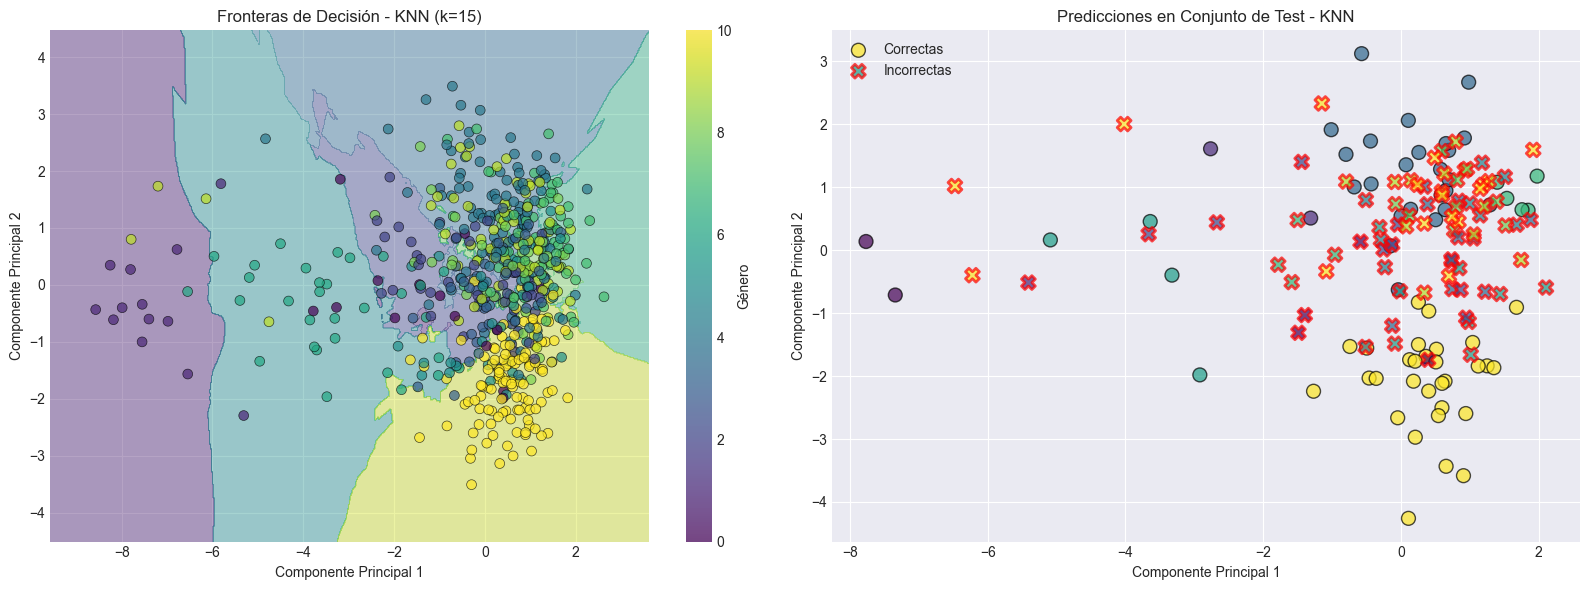


Analizando distancias a vecinos más cercanos...


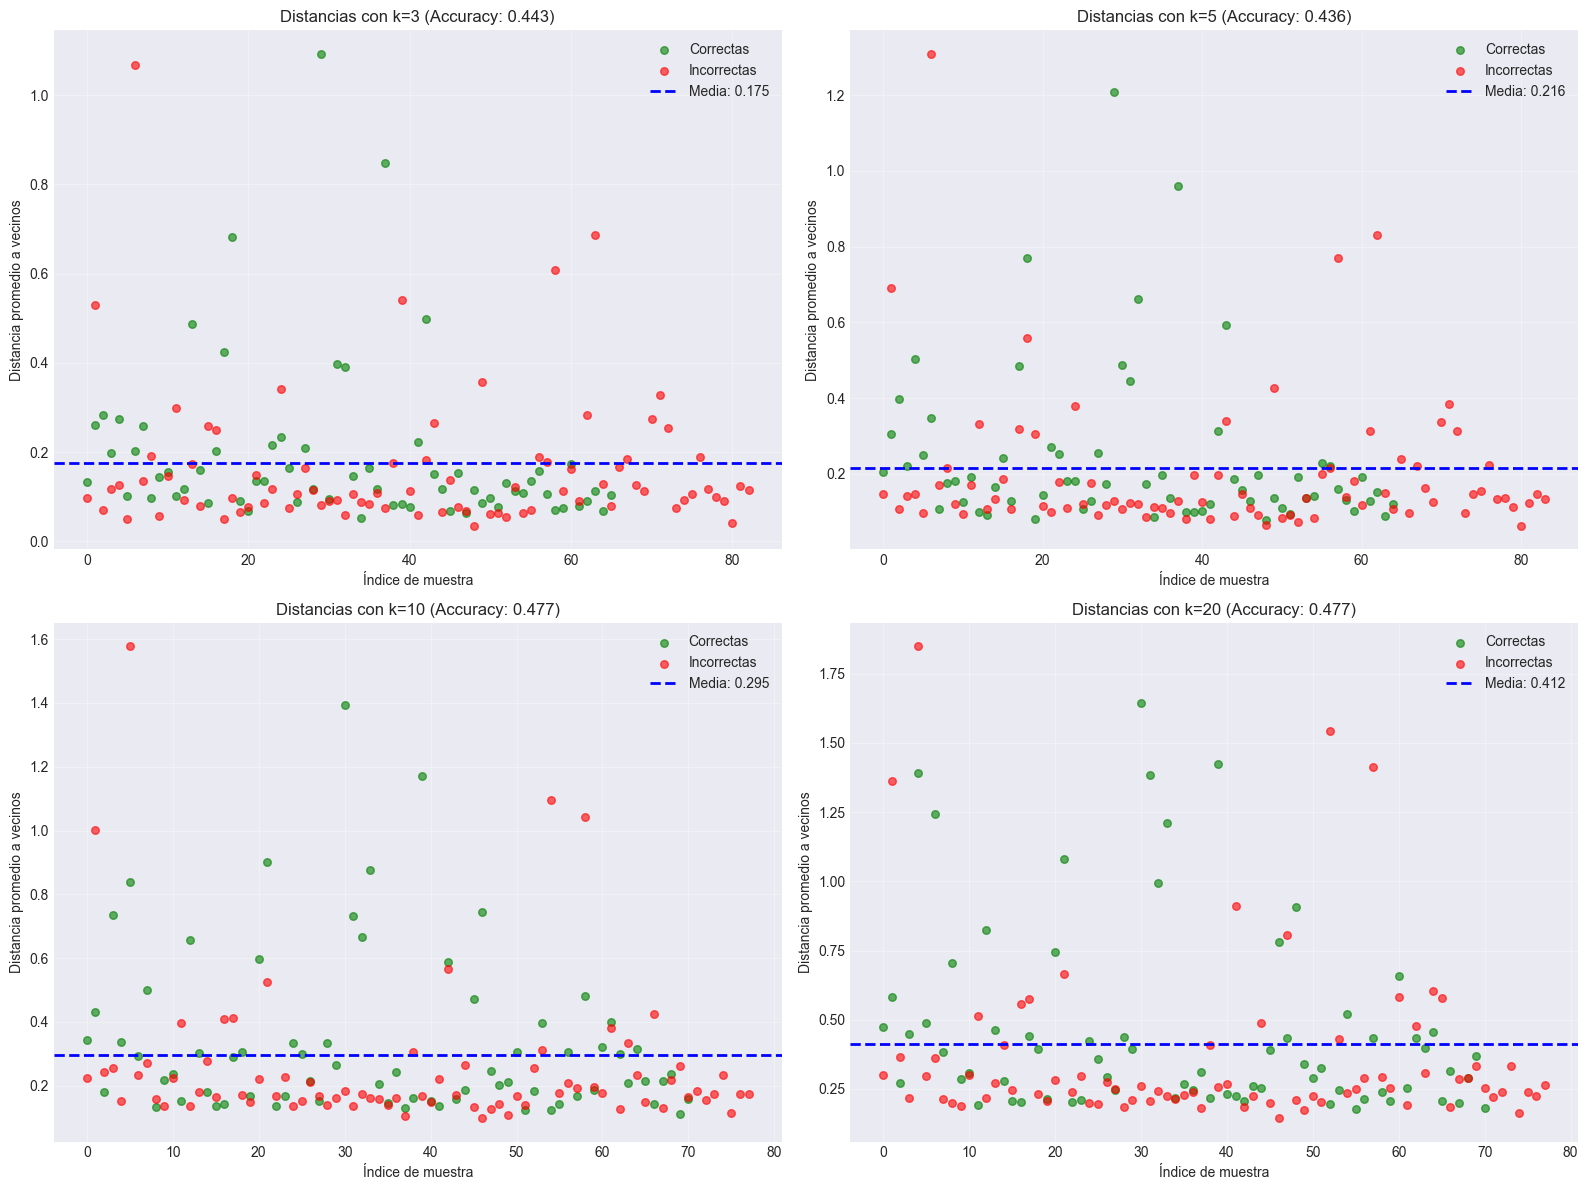


Generando visualización 3D con PCA...


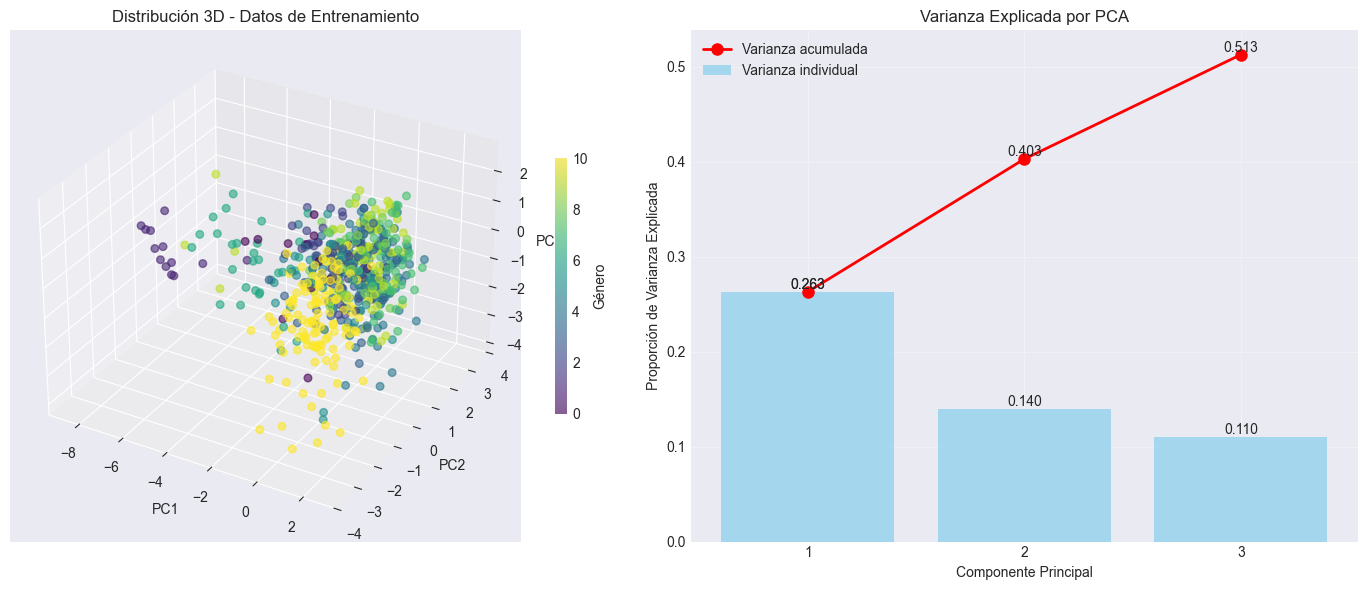


Varianza explicada por componente: [0.26302247 0.13977845 0.10986748]
Varianza total explicada (3 componentes): 0.5127

Generando análisis detallado de Random Forest...


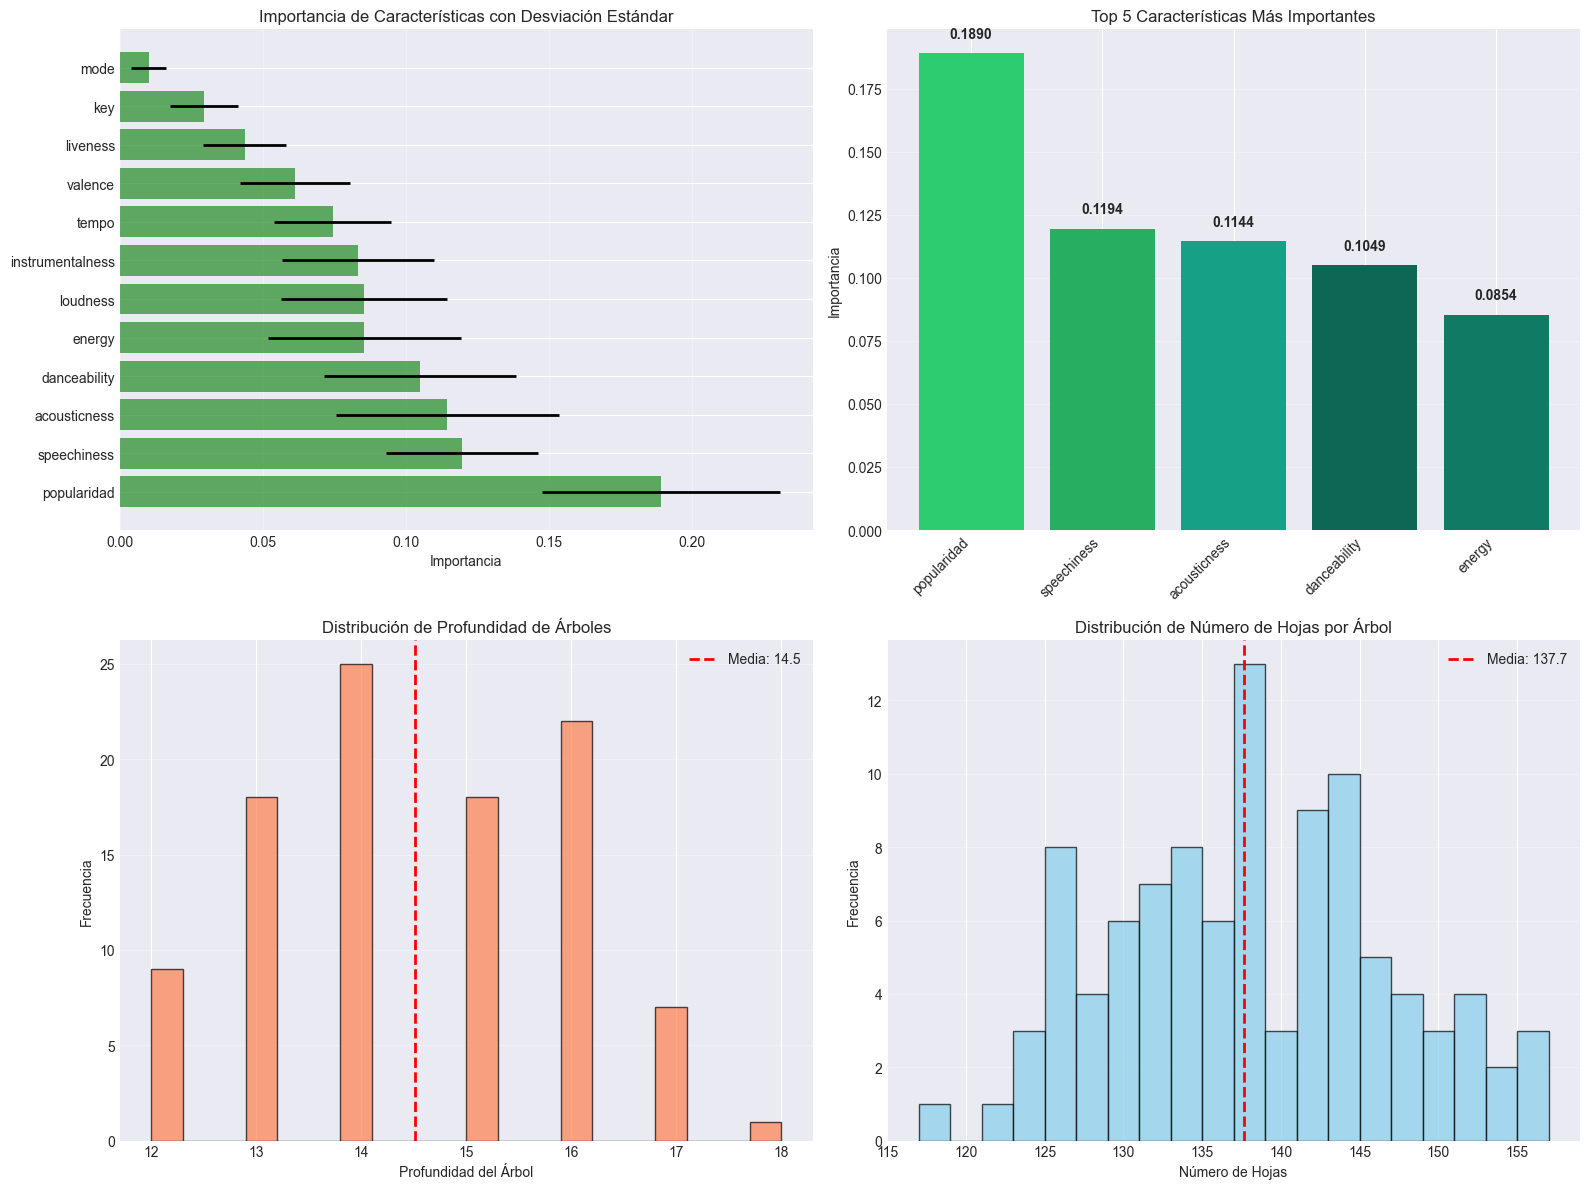


Estadísticas de Random Forest:
  - Profundidad promedio: 14.51 ± 1.46
  - Hojas promedio: 137.68 ± 8.62
  - Número de árboles: 100

Generando curvas de aprendizaje...


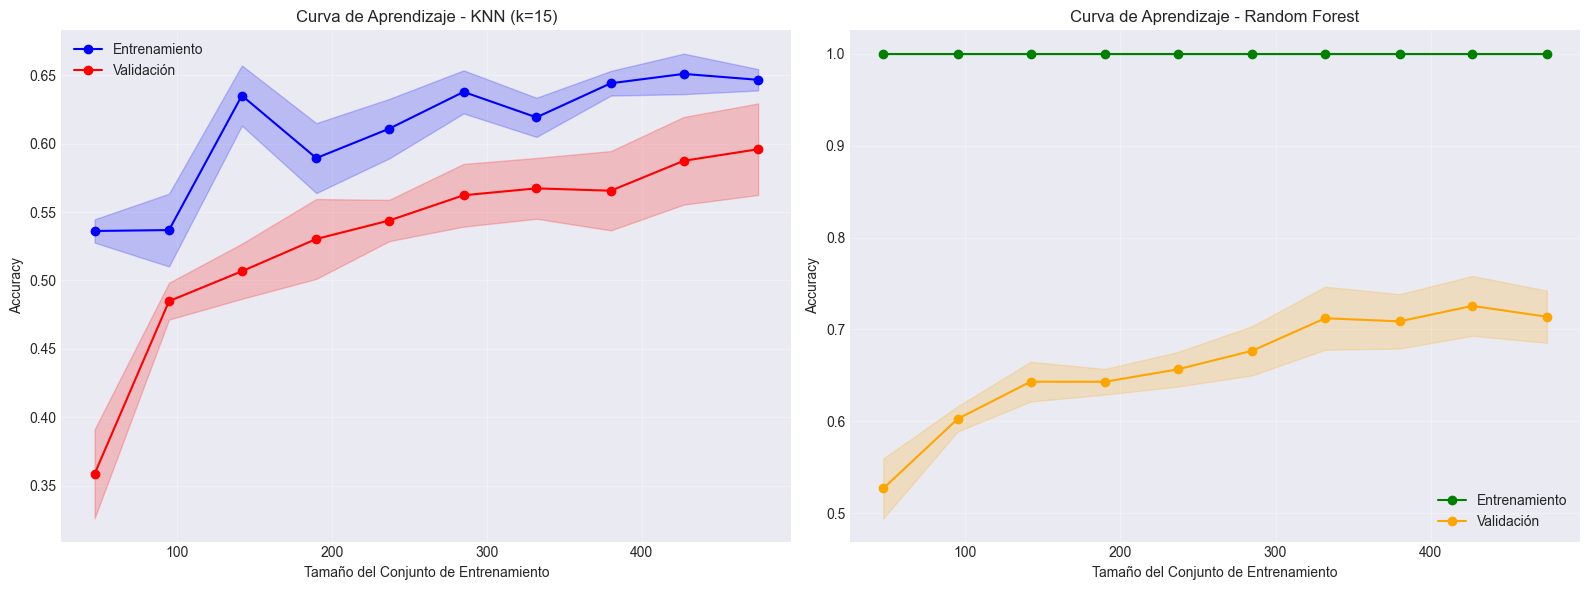


Generando visualización t-SNE (puede tardar un momento)...


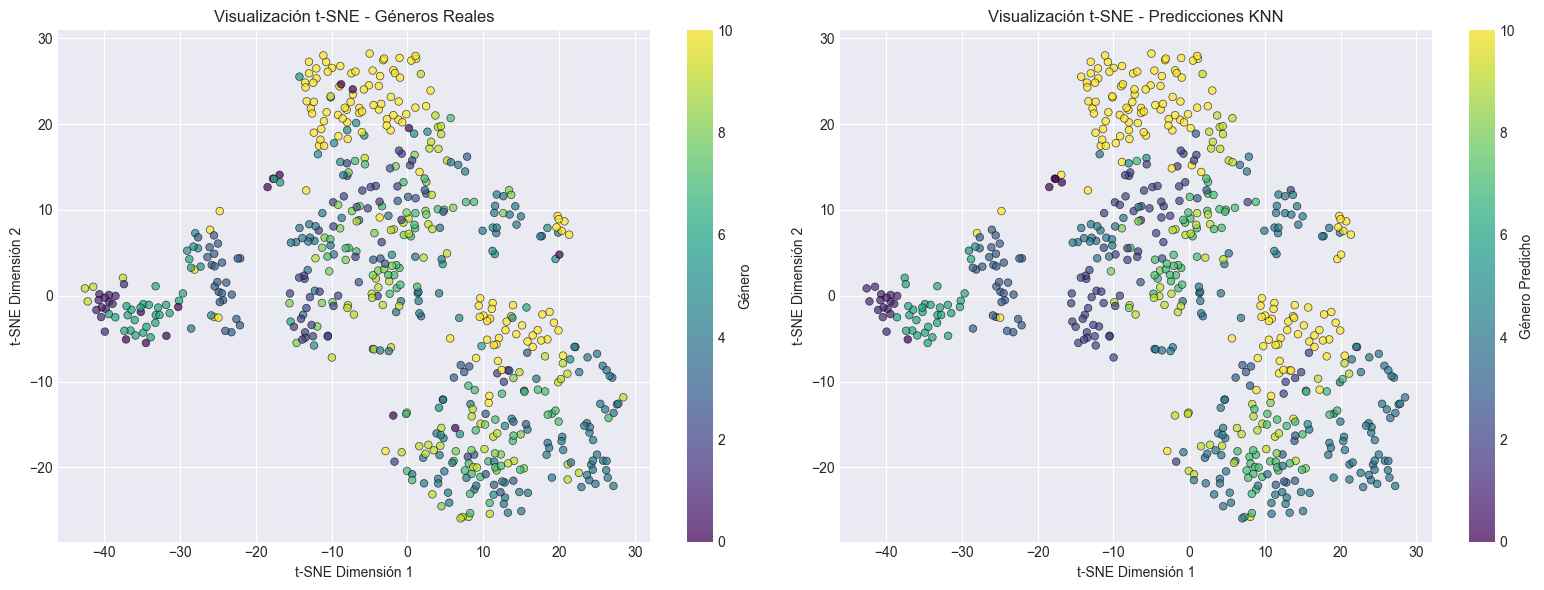


Generando matriz de correlación...


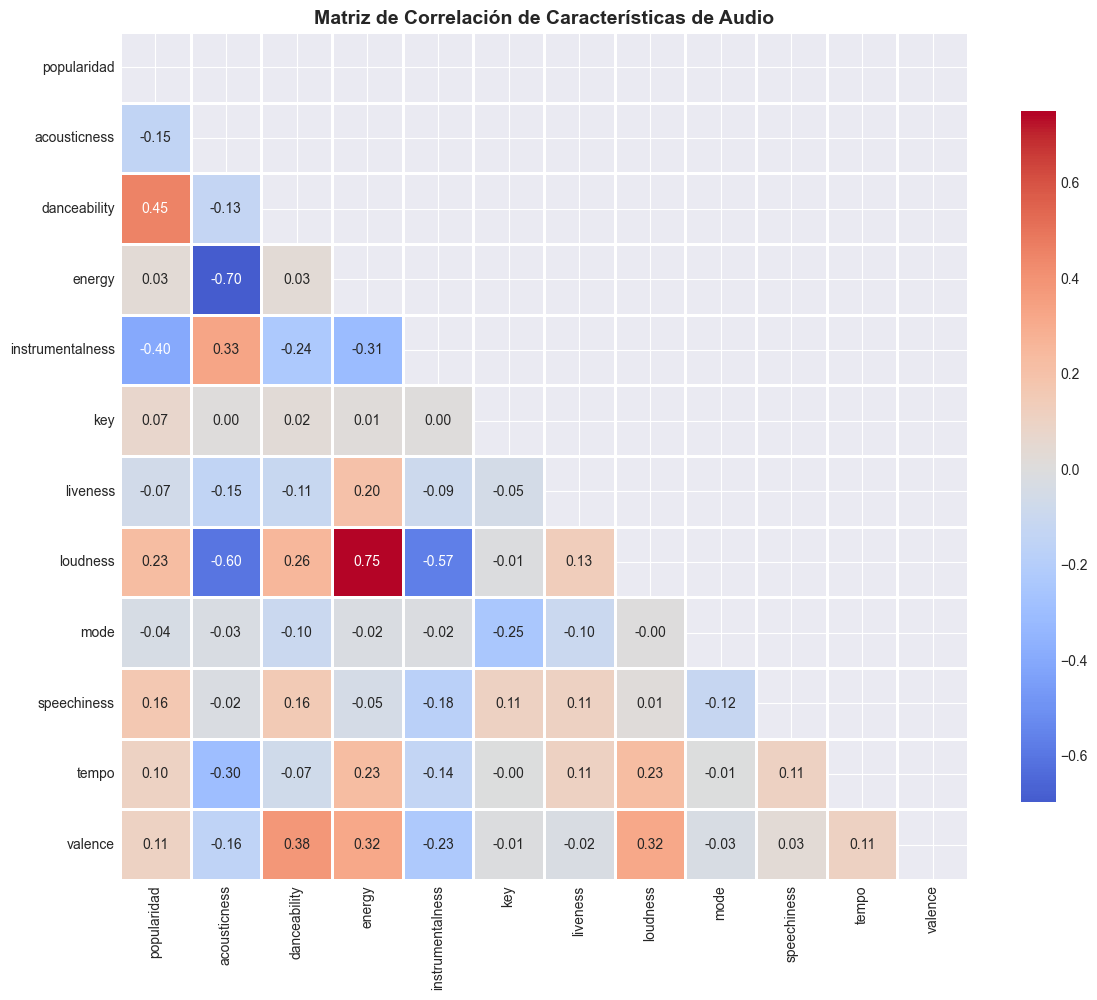


VISUALIZACIONES COMPLETADAS

  Se han generado los siguientes gráficos:
   1. knn_fronteras_decision.png
   2. knn_analisis_distancias.png
   3. knn_pca_3d.png
   4. random_forest_analisis_detallado.png
   5. curvas_aprendizaje.png
   6. tsne_visualizacion.png
   7. matriz_correlacion_features.png


In [ ]:
""" import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import warnings
warnings.filterwarnings('ignore')
 """
print("="*70)
print("VISUALIZACIONES AVANZADAS - KNN Y RANDOM FOREST")
print("="*70)

# ============================================================================
# 1. VISUALIZACIÓN DE FRONTERAS DE DECISIÓN (KNN)
# ============================================================================
print("\nGenerando visualización de fronteras de decisión para KNN...")

# Usar PCA para reducir a 2 dimensiones para visualización
pca_2d = PCA(n_components=2, random_state=42)
X_train_pca = pca_2d.fit_transform(X_train_scaled)
X_test_pca = pca_2d.transform(X_test_scaled)

# Crear meshgrid para visualizar fronteras
h = 0.02  # tamaño del paso en la malla
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Entrenar KNN en datos PCA
from sklearn.neighbors import KNeighborsClassifier
knn_pca = KNeighborsClassifier(n_neighbors=best_k)
knn_pca.fit(X_train_pca, y_train)

# Predecir en toda la malla
Z = knn_pca.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Crear figura con subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Subplot 1: Fronteras de decisión
axes[0].contourf(xx, yy, Z, alpha=0.4, cmap='viridis')
scatter = axes[0].scatter(X_train_pca[:, 0], X_train_pca[:, 1],
                         c=y_train, cmap='viridis',
                         edgecolors='black', linewidth=0.5, s=50, alpha=0.7)
axes[0].set_xlabel('Componente Principal 1')
axes[0].set_ylabel('Componente Principal 2')
axes[0].set_title(f'Fronteras de Decisión - KNN (k={best_k})')
plt.colorbar(scatter, ax=axes[0], label='Género')

# Subplot 2: Puntos de test con predicciones
y_pred_pca = knn_pca.predict(X_test_pca)
correct = y_pred_pca == y_test
axes[1].scatter(X_test_pca[correct, 0], X_test_pca[correct, 1],
               c=y_test[correct], cmap='viridis',
               edgecolors='black', linewidth=1, s=100,
               alpha=0.7, marker='o', label='Correctas')
axes[1].scatter(X_test_pca[~correct, 0], X_test_pca[~correct, 1],
               c=y_test[~correct], cmap='viridis',
               edgecolors='red', linewidth=2, s=100,
               alpha=0.7, marker='X', label='Incorrectas')
axes[1].set_xlabel('Componente Principal 1')
axes[1].set_ylabel('Componente Principal 2')
axes[1].set_title('Predicciones en Conjunto de Test - KNN')
axes[1].legend()

plt.tight_layout()
plt.savefig('../reports/figures/knn_fronteras_decision.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# 2. ANÁLISIS DE DISTANCIAS DE VECINOS (KNN)
# ============================================================================
print("\nAnalizando distancias a vecinos más cercanos...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Diferentes valores de k
k_values_viz = [3, 5, 10, 20]

for idx, k in enumerate(k_values_viz):
    ax = axes[idx // 2, idx % 2]

    knn_temp = KNeighborsClassifier(n_neighbors=k)
    knn_temp.fit(X_train_pca, y_train)

    # Obtener distancias y vecinos
    distances, indices = knn_temp.kneighbors(X_test_pca)

    # Visualizar distribución de distancias promedio
    mean_distances = distances.mean(axis=1)

    # Colorear por predicción correcta/incorrecta
    y_pred_temp = knn_temp.predict(X_test_pca)
    correct_temp = y_pred_temp == y_test

    ax.scatter(range(len(mean_distances[correct_temp])),
              mean_distances[correct_temp],
              c='green', alpha=0.6, s=30, label='Correctas')
    ax.scatter(range(len(mean_distances[~correct_temp])),
              mean_distances[~correct_temp],
              c='red', alpha=0.6, s=30, label='Incorrectas')

    ax.axhline(y=mean_distances.mean(), color='blue',
              linestyle='--', linewidth=2, label=f'Media: {mean_distances.mean():.3f}')
    ax.set_xlabel('Índice de muestra')
    ax.set_ylabel('Distancia promedio a vecinos')
    ax.set_title(f'Distancias con k={k} (Accuracy: {(correct_temp.sum()/len(correct_temp)):.3f})')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/knn_analisis_distancias.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# 3. VISUALIZACIÓN 3D CON PCA (KNN)
# ============================================================================
print("\nGenerando visualización 3D con PCA...")

# PCA a 3 componentes
pca_3d = PCA(n_components=3, random_state=42)
X_train_pca_3d = pca_3d.fit_transform(X_train_scaled)

fig = plt.figure(figsize=(14, 6))

# Subplot 1: Datos de entrenamiento
ax1 = fig.add_subplot(121, projection='3d')
scatter1 = ax1.scatter(X_train_pca_3d[:, 0],
                       X_train_pca_3d[:, 1],
                       X_train_pca_3d[:, 2],
                       c=y_train, cmap='viridis', s=30, alpha=0.6)
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_zlabel('PC3')
ax1.set_title('Distribución 3D - Datos de Entrenamiento')
plt.colorbar(scatter1, ax=ax1, label='Género', shrink=0.5)

# Subplot 2: Varianza explicada
ax2 = fig.add_subplot(122)
variance_ratio = pca_3d.explained_variance_ratio_
cumulative_variance = np.cumsum(variance_ratio)

ax2.bar(range(1, 4), variance_ratio, alpha=0.7, label='Varianza individual', color='skyblue')
ax2.plot(range(1, 4), cumulative_variance, 'ro-', linewidth=2,
         label='Varianza acumulada', markersize=8)
ax2.set_xlabel('Componente Principal')
ax2.set_ylabel('Proporción de Varianza Explicada')
ax2.set_title('Varianza Explicada por PCA')
ax2.set_xticks(range(1, 4))
ax2.legend()
ax2.grid(True, alpha=0.3)

for i, (var, cum_var) in enumerate(zip(variance_ratio, cumulative_variance)):
    ax2.text(i+1, var, f'{var:.3f}', ha='center', va='bottom')
    ax2.text(i+1, cum_var, f'{cum_var:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('../reports/figures/knn_pca_3d.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nVarianza explicada por componente: {variance_ratio}")
print(f"Varianza total explicada (3 componentes): {cumulative_variance[-1]:.4f}")

# ============================================================================
# 4. ANÁLISIS DETALLADO DE RANDOM FOREST
# ============================================================================
print("\nGenerando análisis detallado de Random Forest...")

# Importancia de características con intervalos de confianza
rf_model = resultados['Random Forest']['modelo']

# Calcular importancia de cada árbol
importances = rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Crear DataFrame ordenado
feature_importance_df = pd.DataFrame({
    'Feature': [features_audio[i] for i in indices],
    'Importance': importances[indices],
    'Std': std[indices]
})

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Subplot 1: Importancia con barras de error
axes[0, 0].barh(range(len(importances)), importances[indices],
                xerr=std[indices], align='center',
                color='forestgreen', alpha=0.7, error_kw={'linewidth': 2})
axes[0, 0].set_yticks(range(len(importances)))
axes[0, 0].set_yticklabels([features_audio[i] for i in indices])
axes[0, 0].set_xlabel('Importancia')
axes[0, 0].set_title('Importancia de Características con Desviación Estándar')
axes[0, 0].grid(True, alpha=0.3, axis='x')

# Subplot 2: Top 5 características vs rendimiento
top_5_features = [features_audio[i] for i in indices[:5]]
top_5_importance = importances[indices[:5]]

axes[0, 1].bar(range(5), top_5_importance, color=['#2ecc71', '#27ae60', '#16a085', '#0e6655', '#117a65'])
axes[0, 1].set_xticks(range(5))
axes[0, 1].set_xticklabels(top_5_features, rotation=45, ha='right')
axes[0, 1].set_ylabel('Importancia')
axes[0, 1].set_title('Top 5 Características Más Importantes')
axes[0, 1].grid(True, alpha=0.3, axis='y')

for i, v in enumerate(top_5_importance):
    axes[0, 1].text(i, v + 0.005, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

# Subplot 3: Profundidad de árboles
tree_depths = [tree.tree_.max_depth for tree in rf_model.estimators_]
axes[1, 0].hist(tree_depths, bins=20, color='coral', alpha=0.7, edgecolor='black')
axes[1, 0].axvline(np.mean(tree_depths), color='red', linestyle='--',
                   linewidth=2, label=f'Media: {np.mean(tree_depths):.1f}')
axes[1, 0].set_xlabel('Profundidad del Árbol')
axes[1, 0].set_ylabel('Frecuencia')
axes[1, 0].set_title('Distribución de Profundidad de Árboles')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Subplot 4: Número de hojas
tree_leaves = [tree.tree_.n_leaves for tree in rf_model.estimators_]
axes[1, 1].hist(tree_leaves, bins=20, color='skyblue', alpha=0.7, edgecolor='black')
axes[1, 1].axvline(np.mean(tree_leaves), color='red', linestyle='--',
                   linewidth=2, label=f'Media: {np.mean(tree_leaves):.1f}')
axes[1, 1].set_xlabel('Número de Hojas')
axes[1, 1].set_ylabel('Frecuencia')
axes[1, 1].set_title('Distribución de Número de Hojas por Árbol')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../reports/figures/random_forest_analisis_detallado.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nEstadísticas de Random Forest:")
print(f"  - Profundidad promedio: {np.mean(tree_depths):.2f} ± {np.std(tree_depths):.2f}")
print(f"  - Hojas promedio: {np.mean(tree_leaves):.2f} ± {np.std(tree_leaves):.2f}")
print(f"  - Número de árboles: {len(rf_model.estimators_)}")

# ============================================================================
# 5. CURVA DE APRENDIZAJE (AMBOS MODELOS)
# ============================================================================
print("\nGenerando curvas de aprendizaje...")

from sklearn.model_selection import learning_curve

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Curva de aprendizaje para KNN
train_sizes, train_scores_knn, val_scores_knn = learning_curve(
    resultados['KNN']['modelo'], X_train_scaled, y_train,
    cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='accuracy'
)

train_mean_knn = np.mean(train_scores_knn, axis=1)
train_std_knn = np.std(train_scores_knn, axis=1)
val_mean_knn = np.mean(val_scores_knn, axis=1)
val_std_knn = np.std(val_scores_knn, axis=1)

axes[0].plot(train_sizes, train_mean_knn, 'o-', color='blue', label='Entrenamiento')
axes[0].fill_between(train_sizes, train_mean_knn - train_std_knn,
                     train_mean_knn + train_std_knn, alpha=0.2, color='blue')
axes[0].plot(train_sizes, val_mean_knn, 'o-', color='red', label='Validación')
axes[0].fill_between(train_sizes, val_mean_knn - val_std_knn,
                     val_mean_knn + val_std_knn, alpha=0.2, color='red')
axes[0].set_xlabel('Tamaño del Conjunto de Entrenamiento')
axes[0].set_ylabel('Accuracy')
axes[0].set_title(f'Curva de Aprendizaje - KNN (k={best_k})')
axes[0].legend(loc='best')
axes[0].grid(True, alpha=0.3)

# Curva de aprendizaje para Random Forest
train_sizes, train_scores_rf, val_scores_rf = learning_curve(
    resultados['Random Forest']['modelo'], X_train_scaled, y_train,
    cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='accuracy'
)

train_mean_rf = np.mean(train_scores_rf, axis=1)
train_std_rf = np.std(train_scores_rf, axis=1)
val_mean_rf = np.mean(val_scores_rf, axis=1)
val_std_rf = np.std(val_scores_rf, axis=1)

axes[1].plot(train_sizes, train_mean_rf, 'o-', color='green', label='Entrenamiento')
axes[1].fill_between(train_sizes, train_mean_rf - train_std_rf,
                     train_mean_rf + train_std_rf, alpha=0.2, color='green')
axes[1].plot(train_sizes, val_mean_rf, 'o-', color='orange', label='Validación')
axes[1].fill_between(train_sizes, val_mean_rf - val_std_rf,
                     val_mean_rf + val_std_rf, alpha=0.2, color='orange')
axes[1].set_xlabel('Tamaño del Conjunto de Entrenamiento')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Curva de Aprendizaje - Random Forest')
axes[1].legend(loc='best')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/curvas_aprendizaje.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# 6. VISUALIZACIÓN T-SNE
# ============================================================================
print("\nGenerando visualización t-SNE (puede tardar un momento)...")

# Reducir a 2D con t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_train_tsne = tsne.fit_transform(X_train_scaled[:1000])  # Usar subset para velocidad
y_train_subset = y_train[:1000]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# t-SNE coloreado por género real
scatter1 = axes[0].scatter(X_train_tsne[:, 0], X_train_tsne[:, 1],
                          c=y_train_subset, cmap='viridis',
                          s=30, alpha=0.7, edgecolors='black', linewidth=0.5)
axes[0].set_xlabel('t-SNE Dimensión 1')
axes[0].set_ylabel('t-SNE Dimensión 2')
axes[0].set_title('Visualización t-SNE - Géneros Reales')
plt.colorbar(scatter1, ax=axes[0], label='Género')

# t-SNE con predicciones KNN
knn_for_tsne = KNeighborsClassifier(n_neighbors=best_k)
knn_for_tsne.fit(X_train_scaled[:1000], y_train_subset)
y_pred_tsne = knn_for_tsne.predict(X_train_scaled[:1000])

scatter2 = axes[1].scatter(X_train_tsne[:, 0], X_train_tsne[:, 1],
                          c=y_pred_tsne, cmap='viridis',
                          s=30, alpha=0.7, edgecolors='black', linewidth=0.5)
axes[1].set_xlabel('t-SNE Dimensión 1')
axes[1].set_ylabel('t-SNE Dimensión 2')
axes[1].set_title('Visualización t-SNE - Predicciones KNN')
plt.colorbar(scatter2, ax=axes[1], label='Género Predicho')

plt.tight_layout()
plt.savefig('../reports/figures/tsne_visualizacion.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# 7. MATRIZ DE CORRELACIÓN DE CARACTERÍSTICAS
# ============================================================================
print("\nGenerando matriz de correlación...")

plt.figure(figsize=(12, 10))
correlation_matrix = X_train[features_audio].corr()

# Crear máscara para triángulo superior
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f',
            cmap='coolwarm', center=0, square=True, linewidths=1,
            cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correlación de Características de Audio', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../reports/figures/matriz_correlacion_features.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print("VISUALIZACIONES COMPLETADAS")
print("="*70)
print("\n  Se han generado los siguientes gráficos:")
print("   1. knn_fronteras_decision.png")
print("   2. knn_analisis_distancias.png")
print("   3. knn_pca_3d.png")
print("   4. random_forest_analisis_detallado.png")
print("   5. curvas_aprendizaje.png")
print("   6. tsne_visualizacion.png")
print("   7. matriz_correlacion_features.png")

# testeo random forest

In [15]:
# 🔧 1️⃣ Definir el modelo base
rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)

# 🔍 2️⃣ Definir la grilla de hiperparámetros a probar
param_grid = {
    'n_estimators': [100,150],              # Número de árboles
    'max_depth': [13,14,15],              # Profundidad máxima de los árboles
    'min_samples_split': [4,5,6],              # Mínimo de muestras para dividir un nodo
    'min_samples_leaf': [1,2,3],                # Mínimo de muestras por hoja
    'class_weight': ['balanced'],              # Peso de las clases
    'criterion': ['gini'],          # Medida
    'bootstrap': [False]                    # Si usar muestreo con reemplazo
}

# ⚙️ 3️⃣ Configurar la búsqueda con validación cruzada
grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=5,                      # 5 particiones de validación cruzada
    scoring='f1_weighted',     # métrica para comparar
    n_jobs=-1,                 # usa todos los núcleos disponibles
    verbose=2                  # muestra el progreso
)

# 🚀 4️⃣ Ejecutar la búsqueda
grid_search.fit(X_train_scaled, y_train)

# 📈 5️⃣ Mostrar los mejores resultados
print("✅ Mejor combinación de hiperparámetros:")
print(grid_search.best_params_)
print(f"\n🏆 Mejor F1-score promedio: {grid_search.best_score_:.4f}")

# 💾 6️⃣ Guardar el mejor modelo
mejor_modelo = grid_search.best_estimator_

# 🧩 7️⃣ Evaluar en el conjunto de prueba
y_pred_best = mejor_modelo.predict(X_test_scaled)
print("\n📊 Evaluación del mejor modelo:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred_best, average='weighted'):.4f}")
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_best))


Fitting 5 folds for each of 54 candidates, totalling 270 fits
✅ Mejor combinación de hiperparámetros:
{'bootstrap': False, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 13, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 150}

🏆 Mejor F1-score promedio: 0.7292

📊 Evaluación del mejor modelo:
Accuracy: 0.7919
F1-score: 0.7868

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       1.00      1.00      1.00         3
           2       1.00      0.82      0.90        11
           3       1.00      0.92      0.96        12
           4       0.80      0.93      0.86        30
           5       1.00      0.44      0.62         9
           6       0.89      1.00      0.94         8
           7       0.44      0.57      0.50        14
           8       0.56      0.50      0.53        10
           9       0.64      0.50      0.56        18
          10       0

In [16]:
print("\n Modelo 2: Random Forest")
print("-" * 50)

rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    max_depth=14,
    min_samples_split=5,
    class_weight='balanced',
    criterion='gini',
    bootstrap = False

    )

rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

acc_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')

resultados['Random Forest'] = {
    'modelo': rf,
    'accuracy': acc_rf,
    'f1_score': f1_rf,
    'predictions': y_pred_rf
}

print(f" Accuracy: {acc_rf:.4f}")
print(f" F1-Score: {f1_rf:.4f}")


 Modelo 2: Random Forest
--------------------------------------------------
 Accuracy: 0.7852
 F1-Score: 0.7784
